In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import scipy.signal.windows as windows

#directory with the .hdf5 files
directory = 'LOSC_Event_tutorial/LOSC_Event_tutorial/'

#### Some prior comments on the approach:


Everywhere in the code and the results H stands for Hanford, and L for Livinston.

For the noise model (in Fourier space), a smoothed power spectrum of the data from each event & detector is used. Gaussian smoothing (with a finite Gaussian kernel defined on the interval ($-3\sigma, 3\sigma$)) is used. Lines in the noise are not treated separately, as the Gaussian smoothing has a less drastic effect on them than, say, boxcar smoothing (apart from that, the chosen noise model resulted in better performance than a variation with correction for lines). 


The data is windowed using the Tukey window, which is a sort of combination of a cosine window and a rectangular one:

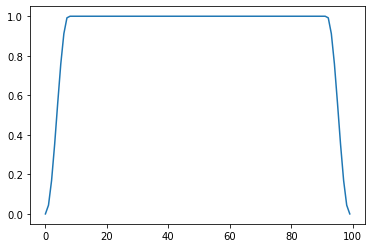

In [2]:
window = windows.tukey(100, alpha = 0.15)
plt.plot(window)
plt.show()

In [3]:
#functions for reading in the data by Prof. Sievers
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl
def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]
    meta=dataFile['meta']
    gpsStart=meta['GPSstart'][()]
    utc=meta['UTCstart'][()]
    duration=meta['Duration'][()]
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)
    dataFile.close()
    return strain,dt,utc

In [4]:
# a function for smoothing a vector of data
def smooth(data, halfwidth, type = 'rectangle'): 
    data_ft = np.fft.rfft(data)
    kernel = np.zeros(len(data))
    if type == 'gauss':  # finite gaussian kernel
        sigma = halfwidth/3 
        x = np.linspace(0, 3*sigma, halfwidth)
        kernel[:halfwidth] = np.exp(-x**2/2./sigma**2)
        kernel[-halfwidth+1:] = np.flipud(kernel[1:halfwidth])        
    else:    
        kernel[:halfwidth] = 1   # boxcar
        kernel[-halfwidth+1:] = 1
    kernel = kernel/sum(kernel)
    kft = np.fft.rfft(kernel)
    smoothed_data = np.fft.irfft(data_ft * kft, len(data))
    return smoothed_data

# noise model from the FT of data
def noise_model(strain_ft):
    N1 = np.abs(strain_ft)**2 # take the Fourier power spectrum
    N2 = smooth(N1, 24, type = 'gauss')
#     print('Checking power conservation:',np.sum(N1), np.sum(N2))
    N = np.maximum(N1, N2)  # maximum can be taken to keep the peaks unsmoothed 
    return N2  #but it turned out that the smoothed model (N2) works better than N 

# a function that applies the MF + some calculations needed for (c)-(e) 
def match_filter(strain, template, dt):
    window = windows.tukey(len(strain), alpha = 0.15)  # a window with an extended flat region
    strain_windowed = strain*window
    strain_ft = np.fft.rfft(strain_windowed, norm = 'ortho')
    N = noise_model(strain_ft)  
    sigma = np.sqrt(N)
    
    template_ft = np.fft.rfft(template*window, norm = 'ortho')
    strain_white = strain_ft/sigma  #pre-whitening the data
    templ_white = template_ft/sigma  #pre-whitening the template      
    match_ft = np.conj(templ_white)*strain_white
    match = np.fft.irfft(match_ft, norm = 'ortho') # output of the MF in time
    
    # analytic calculation of sigma_m (noise in the output of the MF)
    # the pre-whitened template is used
    templ_white_real = np.fft.irfft(templ_white, norm = 'ortho')
    var_m = np.mean(templ_white_real**2)
    sigma_m = np.sqrt(var_m)
    
    # calculation of the frequency for (e)
    # the weight of each frequency is determined by the (pre-withened template)^2 
    freqs = np.fft.rfftfreq(len(strain), d = dt)
    powers = np.abs(templ_white)**2  
    total = sum(powers)
    cumulative = np.cumsum(powers)/total   
    k = np.argmin(np.abs(cumulative - 0.5))
    freq_halfweight = freqs[k]
    
    return match, N, sigma_m, freq_halfweight



           ｡･✧:*:･ﾟ★｡･:*:･ﾟ☆ Event GW170104 ｡･:*:･ﾟ★｡･:*✧:･ﾟ☆



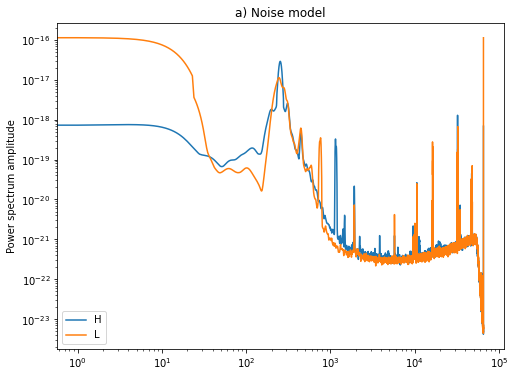

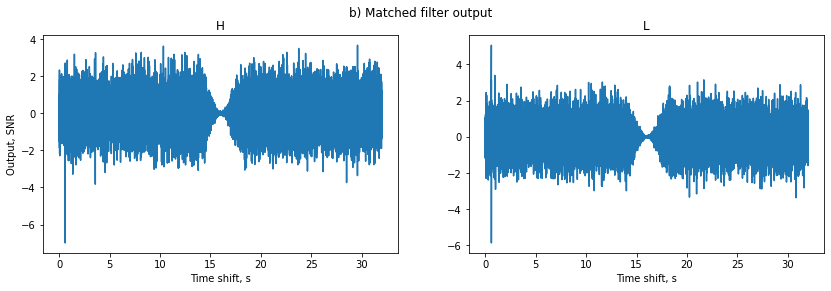


c) SNRs| H: 6.9892 L: 5.8682 combined: 9.1260

d) SNRs analytic| H: 8.0115 L: 7.4412

e) 'Half-weight' frequency of the templates: H: 96.4688 Hz, L: 75.5312 Hz



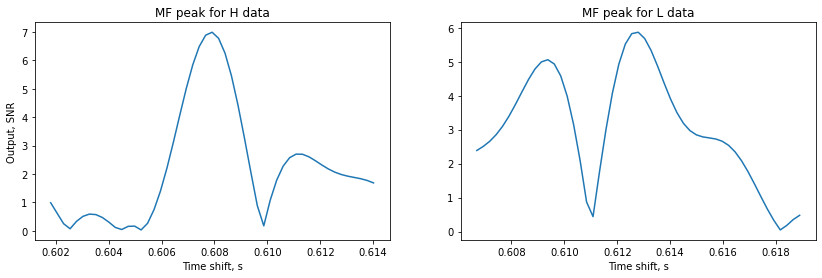



           ｡･✧:*:･ﾟ★｡･:*:･ﾟ☆ Event GW150914 ｡･:*:･ﾟ★｡･:*✧:･ﾟ☆



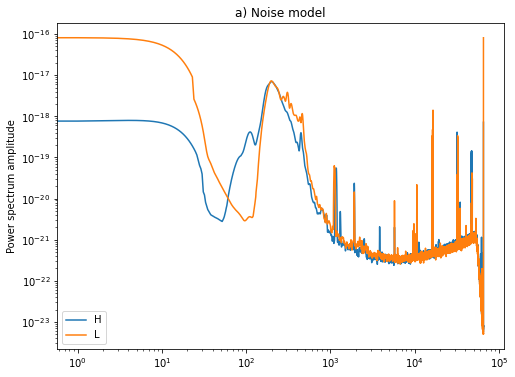

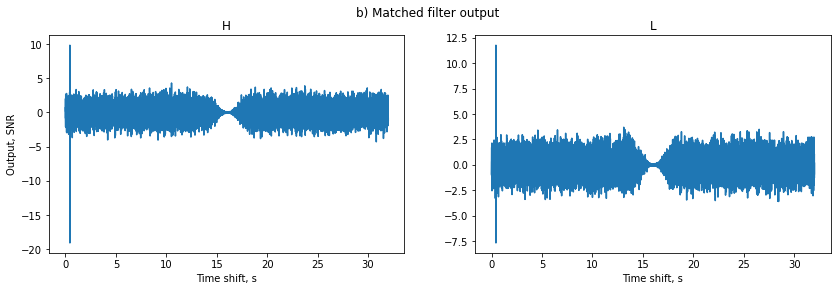


c) SNRs| H: 19.1075 L: 11.7612 combined: 22.4371

d) SNRs analytic| H: 18.2698 L: 12.7352

e) 'Half-weight' frequency of the templates: H: 103.3750 Hz, L: 116.1562 Hz



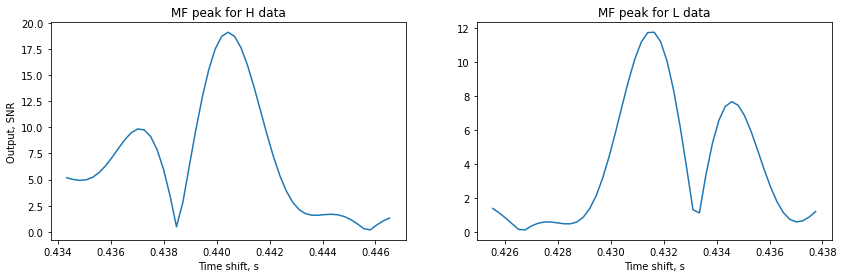



           ｡･✧:*:･ﾟ★｡･:*:･ﾟ☆ Event LVT151012 ｡･:*:･ﾟ★｡･:*✧:･ﾟ☆



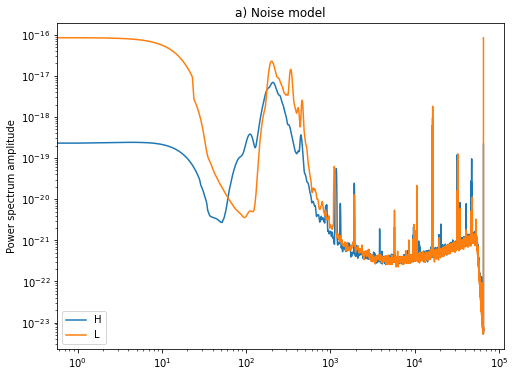

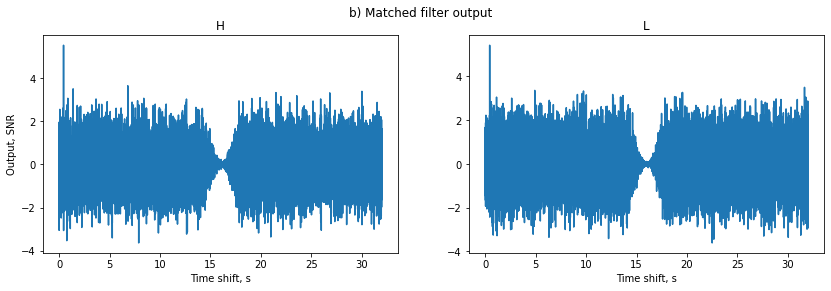


c) SNRs| H: 5.5249 L: 5.4282 combined: 7.7454

d) SNRs analytic| H: 6.3358 L: 5.9195

e) 'Half-weight' frequency of the templates: H: 79.5000 Hz, L: 97.5312 Hz



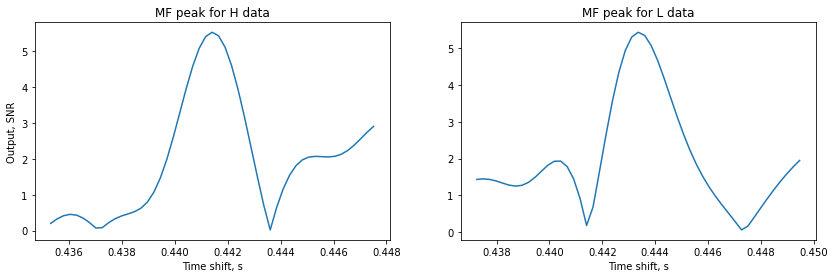



           ｡･✧:*:･ﾟ★｡･:*:･ﾟ☆ Event GW151226 ｡･:*:･ﾟ★｡･:*✧:･ﾟ☆



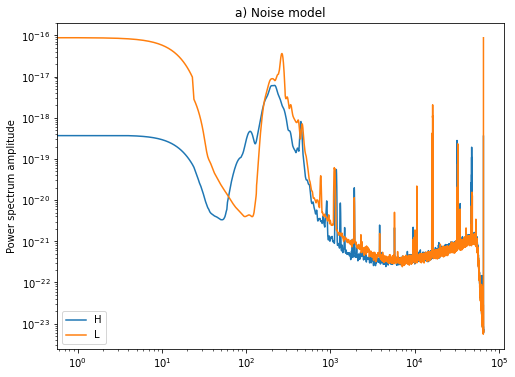

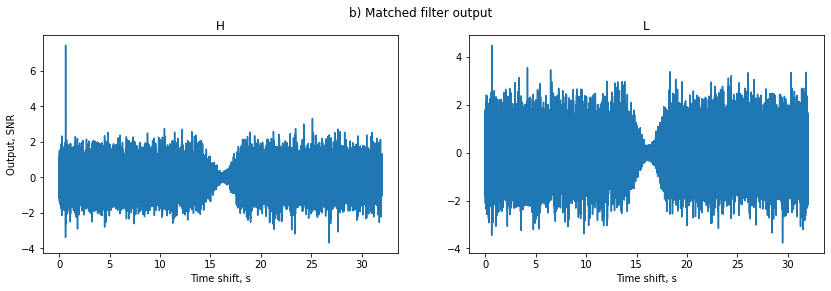


c) SNRs| H: 7.4402 L: 4.4808 combined: 8.6853

d) SNRs analytic| H: 10.0448 L: 5.3905

e) 'Half-weight' frequency of the templates: H: 77.7188 Hz, L: 108.3750 Hz



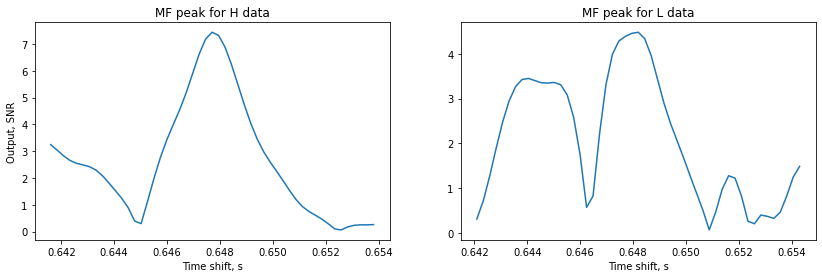

In [5]:
# application to each event + printing the results & making plots

event_names = ["GW170104", "GW150914", "LVT151012", "GW151226"]
file_names = ['V1-1167559920-32', 'V2-1126259446-32', 'V2-1128678884-32', 'V2-1135136334-32']
Hprefix = 'H-H1_LOSC_4_'
Lprefix = 'L-L1_LOSC_4_'

for ind, event in enumerate(event_names):
    print(); print()
    print('          ','｡･✧:*:･ﾟ★｡･:*:･ﾟ☆','Event', event, '｡･:*:･ﾟ★｡･:*✧:･ﾟ☆')
    print()
    Hname = directory + Hprefix + file_names[ind] + '.hdf5'  
    Lname = directory + Lprefix + file_names[ind] + '.hdf5'
    template_name = directory+event_names[ind]+'_4_template.hdf5'
    # read in the files
    Hstrain,dt1,utc1 = read_file(Hname)
    Lstrain,dt2, utc2 = read_file(Lname)
    th,tl = read_template(template_name)
    times = np.array(range(len(Hstrain)))*dt1 #values on the horizontal axis (data spacing dt1 = dt2 for each event)
    
    ###########################################################################
    
    # apply the MF
    Hmatch, NH, sigmaN, freqH = match_filter(Hstrain, th, dt1)
    Lmatch, NL, sigmaL, freqL = match_filter(Lstrain, tl, dt1)
    
    # calculate the scatter of the output for the SNR
    # taking a region where the output is not repressed by the window
    scatterH = np.std(Hmatch[2000:4000]) 
    scatterL = np.std(Lmatch[2000:4000])
    
    # calculate the SNR for each event + combined
    SNRH = np.max(np.abs(Hmatch))/scatterH
    SNRL = np.max(np.abs(Lmatch))/scatterL
    combinedSNR = np.sqrt(SNRH**2 + SNRL**2)
    
    # calculate the analytic (expected) SNR
    SNRHa = np.max(np.abs(Hmatch))/sigmaN
    SNRLa = np.max(np.abs(Lmatch))/sigmaL
    
    # time of the signal arrival (location of the peak of the MF output) 
    tH = np.argmax(np.abs(Hmatch))
    tL = np.argmax(np.abs(Lmatch))
    
    ####################################################################
    # plots and printing
    plt.figure(figsize = (8,6))
    plt.loglog(np.sqrt(NH), label = 'H')
    plt.loglog(np.sqrt(NL), label = 'L')
    plt.title('a) Noise model')
    plt.ylabel('Power spectrum amplitude')
    plt.legend()
    plt.show()
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,4))
    ax1.plot(times, Hmatch/scatterH)
    ax1.set(xlabel = ('Time shift, s'), ylabel = 'Output, SNR')
    ax1.set_title('H')
    ax2.plot(times, Lmatch/scatterL)
    ax2.set(xlabel = ('Time shift, s'))
    ax2.set_title('L')
    fig.suptitle('b) Matched filter output')
    plt.show()
     
    print()
    print('c) SNRs|', 'H:','%.4f'%SNRH, 'L:', '%.4f'%SNRL, 'combined:', '%.4f'%combinedSNR)
    print()
    print('d) SNRs analytic|', 'H:','%.4f'%SNRHa, 'L:', '%.4f'%SNRLa)
    print()
    print('e) \'Half-weight\' frequency of the templates:','H:', '%.4f'% freqH, 'Hz,','L:', '%.4f'%freqL, 'Hz')
    print()
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,4))
    ax1.plot(times[tH - 25:tH + 26], np.abs(Hmatch[tH - 25:tH + 26])/scatterH)
    ax1.set(xlabel = ('Time shift, s'), ylabel = ('Output, SNR'))
    ax1.set_title('MF peak for H data')
    ax2.plot(times[tL - 25:tL + 26], np.abs(Lmatch[tL - 25:tL + 26])/scatterL)
    ax2.set(xlabel = ('Time shift, s'))
    ax2.set_title('MF peak for L data')
    plt.show()

#### Some comments on the results:

The analytic SNR is a bit higher (overestimated) than the SNR from the scatter in the matched filter. This is probably due to the fact that the noise model is not perfect, but the agreement between the two SNR estimates is still OK. The analytic SNR is ~5%-35% higher that the SNR from scatter.



#### f) Estimating the angular positional uncertainty

The difference of the arrival times of the signal $\Delta t$ due to the path difference $\Delta l$ is related to the positional angle of the source $\theta$:


\begin{equation}
\Delta t = \frac{\Delta l}{c} = d \sin\theta ,
\end{equation}
where $d$ is the distance between the detectors.


Assuming that the uncertainty in $\theta$ arises primarily due to the uncertainty in $\Delta t$ (and not in $d$ or $c$), we have:


\begin{equation}
\delta(\sin \theta) = \cos\theta \delta \theta \sim \frac{c}{d} \delta(\Delta t)
\end{equation}

The uncertainty in the arrival times (see the zoomed-in plots of the peaks in the MF correlation) is ~1.5 spacings between the data points (FWHM estimated by eye). Let's take 2 spacings as the error of their difference (quadrature sum of the 2 errors).

To estimate just the order of $\delta \theta$, we can drop the cosine (say that it is of order one), or say it is ~0.5.

In [6]:
c = 300*10**3 # km/s
d = 3*10**3  # km
timediff_err = 2*dt1 #s
angle_err = c/d*timediff_err/0.5
print('%.4f'% (angle_err/np.pi*180), 'deg')

5.5953 deg


So the estimated positional uncertainty is of order of degrees.